In [1]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

In [2]:
file_names_dir = "BCCD/ImageSets/Main/"
images_dir = "BCCD/JPEGImages/"
labels_dir = "BCCD/Annotations/"

source_file = "test.csv"

In [3]:
df = pd.read_csv(source_file)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   4888 non-null   object
 1   cell_type  4888 non-null   object
 2   xmin       4888 non-null   int64 
 3   xmax       4888 non-null   int64 
 4   ymin       4888 non-null   int64 
 5   ymax       4888 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 229.3+ KB


In [4]:
df.head()

,filename,cell_type,xmin,xmax,ymin,ymax
0,BloodImage_00000.jpg,WBC,260,491,177,376
1,BloodImage_00000.jpg,RBC,78,184,336,435
2,BloodImage_00000.jpg,RBC,63,169,237,336
3,BloodImage_00000.jpg,RBC,214,320,362,461
4,BloodImage_00000.jpg,RBC,414,506,352,445


In [5]:
class_to_idx = {'WBC': 0, 'RBC': 1, "Platelets": 2}
idx_to_class = {idx: class_ for class_, idx in class_to_idx.items()}
idx_to_class

{0: 'WBC', 1: 'RBC', 2: 'Platelets'}

In [6]:
df = df.set_index('filename')
df["cell_type"] = df["cell_type"].map(class_to_idx)
df = df.reindex(columns=['cell_type', 'xmin', 'ymin', 'xmax', 'ymax'])

In [25]:
df.head()

,cell_type,xmin,ymin,xmax,ymax
filename,,,,,
BloodImage_00000.jpg,0,260,177,491,376
BloodImage_00000.jpg,1,78,336,184,435
BloodImage_00000.jpg,1,63,237,169,336
BloodImage_00000.jpg,1,214,362,320,461
BloodImage_00000.jpg,1,414,352,506,445


In [8]:
def read_blood_data(csv_data):
    """Read the blood cell detection dataset images and labels."""

    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(images_dir, f'{img_name}')))
        # Here `target` contains (class, x_min, x_max, y_min, y_max) in pixels
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1)

In [9]:
images, targets = [], []
for img_name, target in df.iterrows():
    images.append(torchvision.io.read_image(
        os.path.join(images_dir, f'{img_name}')))

    targets.append(list(target))

targets_tensor = torch.tensor(targets[0]).unsqueeze(1)
targets_tensor.shape

torch.Size([5, 1])

In [10]:
def train_val_data(mode="train"):
    if "train" in mode:
        data = pd.read_csv(os.path.join(file_names_dir, f"{mode}.txt"), header=None, names=["filename"])
    elif "val" in mode:
        data = pd.read_csv(os.path.join(file_names_dir, f"{mode}.txt"), header=None, names=["filename"])
    else:
        data = pd.read_csv(os.path.join(file_names_dir, f"{mode}.txt"), header=None, names=["filename"])

    filtered_data = df.loc[df.index.intersection(data["filename"]+".jpg")]

    return filtered_data

In [11]:
train_data = train_val_data(mode="train")
val_data = train_val_data(mode="val")
test_data = train_val_data(mode="test")

In [26]:
train_data.head()

,cell_type,xmin,ymin,xmax,ymax
filename,,,,,
BloodImage_00001.jpg,0,68,315,286,480
BloodImage_00001.jpg,1,346,361,446,454
BloodImage_00001.jpg,1,53,179,146,299
BloodImage_00001.jpg,1,449,400,536,480
BloodImage_00001.jpg,1,461,132,548,212


In [27]:
val_data.head()

,cell_type,xmin,ymin,xmax,ymax
filename,,,,,
BloodImage_00000.jpg,0,260,177,491,376
BloodImage_00000.jpg,1,78,336,184,435
BloodImage_00000.jpg,1,63,237,169,336
BloodImage_00000.jpg,1,214,362,320,461
BloodImage_00000.jpg,1,414,352,506,445


In [14]:
train_images, train_labels = read_blood_data(train_data)
train_labels.shape

torch.Size([2805, 1, 5])

In [15]:
tensor = torch.stack(train_images)
print(tensor.shape)
print(len(tensor))

torch.Size([2805, 3, 480, 640])
2805


In [16]:
class BloodDataset(torch.utils.data.Dataset):
    """A customized dataset to load the banana detection dataset."""
    def __init__(self, is_train):
        self.features, self.labels = read_blood_data(train_data if is_train else val_data)
        self.features = torch.stack(self.features)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [17]:
train_dataset = BloodDataset(is_train=True)
val_dataset = BloodDataset(is_train=False)

read 2805 training examples
read 1138 validation examples


In [18]:
def load_blood_data(batch_size):
    """Load the banana detection dataset."""
    train_iter = torch.utils.data.DataLoader(BloodDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BloodDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

In [19]:
batch_size, edge_size = 10, 256
train_iter, _ = load_blood_data(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 2805 training examples
read 1138 validation examples


(torch.Size([10, 3, 480, 640]), torch.Size([10, 1, 5]))

In [20]:
batch[0][:10][2][0]

tensor([[182., 182., 182.,  ..., 180., 177., 174.],
        [183., 183., 183.,  ..., 179., 177., 175.],
        [184., 184., 184.,  ..., 177., 177., 175.],
        ...,
        [178., 178., 178.,  ..., 200., 200., 200.],
        [178., 178., 178.,  ..., 200., 200., 200.],
        [178., 178., 178.,  ..., 200., 200., 200.]])

In [21]:
batch[1][:10][2][0]

tensor([  1, 263, 150, 347, 231])

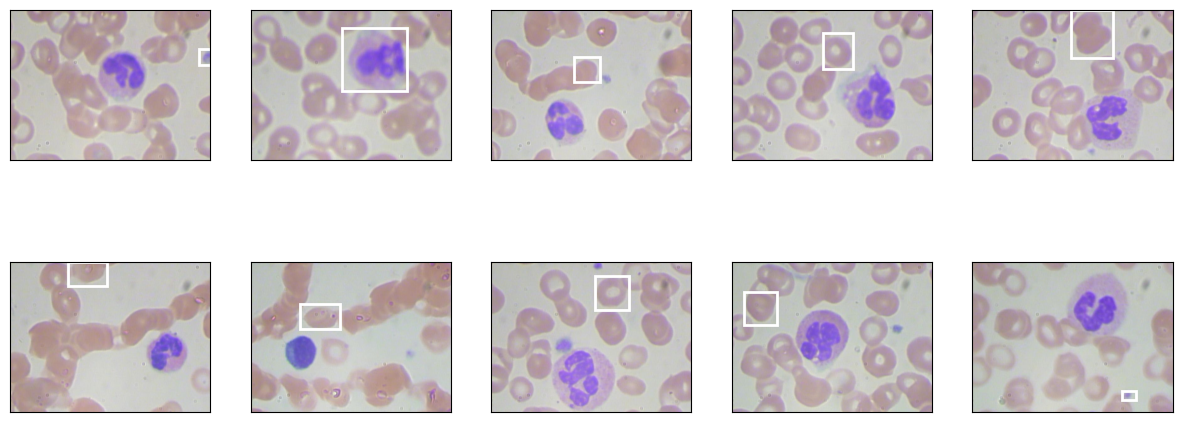

In [22]:
imgs = (batch[0][:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=3)
for ax, label in zip(axes, batch[1][:10]):
    d2l.show_bboxes(ax, [label[0][1:5]], colors=['w'])

In [23]:
batch[0][:1].permute(0, 2, 3, 1).shape

torch.Size([1, 480, 640, 3])

In [24]:
batch[1][:10][0][0][1:5]

tensor([604, 125, 640, 177])